# Project Proposal:  NBA Predictor and Team Operation Module

## Author: Rui Ding 

### Introduction

NBA today is no long only a basketball game of athletic talents and skills. To understand how well can a team perform and what kind of impact 
can an individual player bring about is a task that can not be achieved by pure verbal or conceptual qualification alone. Nowadays, teams utilize the
quantification power produced by data analysis and infer team performance predictions and player values, therefore helpinmg in their decision making processes.

In this project, two modules are proposed to facilitate team performance predictions and decision making.
The NBA Predictor module is a simple system that uses the power of various ways of regression analysis, and based on their predictions infer
how well a team can perform and many other important features of a game or of a team's full season status. The primary predictions are seasonal winning ratios,
per game winner prediction and winning margins based on team strength, current momentum and other factors. 

While fans can see the prediction as a way to estimate their favorite team's performance and maybe assist in basketball lotteries,
such predictions can be genralized and applied to assist in teams' strategy building processes such trades, player evaluations,contract negotiations, etc.
The second proposed module will use the previous predictions and characterize how valuable a player is to the team's success. My aim is to create a 
recommendation engine that provides information for trading, free agent signing, player evaluations and contract estimations.

Overall, these results will help improve a team's building process and provide foundation for continuous success.

    


## NBA Predictor-Regression Models and Key Regressors

To start with, I aim to get the data support from one of the most complete NBA database, basketball-reference.com.
The site contains various types of related stats ranging from player basic statistics, player advanced statistics, team ranking statistics to team advanced statistics.
The first simple model will be to analyze the correlation between individual player’s statistics and their team’s performance, and develops a prediction model that can be used to forecast regular season results of NBA teams based on common player statistics.
One of the best ways to characterize a player's ability and contribution to his team is the advanced stat Player Efficientcy Ratio(PER) developed by former ESPN analyst John Hollinger.
There are many advantages to this simple metric which contains a whole lot of information, the details will be left in the full project description.
Among the most mportant factors for choosing this statistic to be a basis of analysis is that it is a simple evaluation of any individual player, and adjusts
for the pace of the games he played as well as the minutes played. This is a key feature because games today are so different from just a few years ago,
and strtegies from different teams vary a lot, therefore this adjustment keeps the metric fair as a rating of any individual player.

Using the PER values from the advanced data I get from basketball-reference.com, for seasonal prediction I run a simple regression for a team's averaged PER rating against its winning ratio
from the past season(for the current season 2017-2018, the database would be 2016-2017). And for per game prediction I will run
a linear regression taking the PER of home and guest teams against the winning margin of the hometeam. A game winner probability prediction will
model a logistic regression using the same input regressors and the variable being the binary indicator for whether the home team wins or not.
The key regressor averaged PER for a team is formulated as such :
    
AvgPER of $Team_i$ = Sum of (total minutes a player played for $Team_i$ * PER recorded for that player when playing for $Team_i$) 
/ Sum of (total minutes players played for $Team_i$)To account for some players not being a significant part of the team in terms of minutes on court, I put a floor of eight minutes per game when adding player contributions to team average PER.

### Seasonal Winning Ratio Prediction

My goal is to check if this regression model predicts the seasonal status of each team for the 2016-2017 season well based on a model trained using 2015-2016
season statistics(for demonstration I used a stored csv file of 15-16 season data while in practice the application uses data scraping). As input one can enter the avgPER this season calculated as above, and predict the winning ratio using the model coefficients. Moreover, we can adjust for higher accuracy based on real life intuitions, such as we can
leave out players who don't play much(benchwarmers), therefore their minutes don't count in the total contribution. The following code implements this process and we see a $R^2$
of 0.85 for the training dataset and a $R^2$ of 0.64 for the testing dataset. The data points are contributed by the 30 NBA teams and they are plotted below.
For the cell below, an example is shown using locally stored data files in the folder sample_datafiles. In the project applications online data scraping is used so storage is no longer
necessary.


In [11]:
from bs4 import BeautifulSoup
import requests
from datetime import datetime

0.850528089816
[[ 0.1514908]]
[-1.78164681]


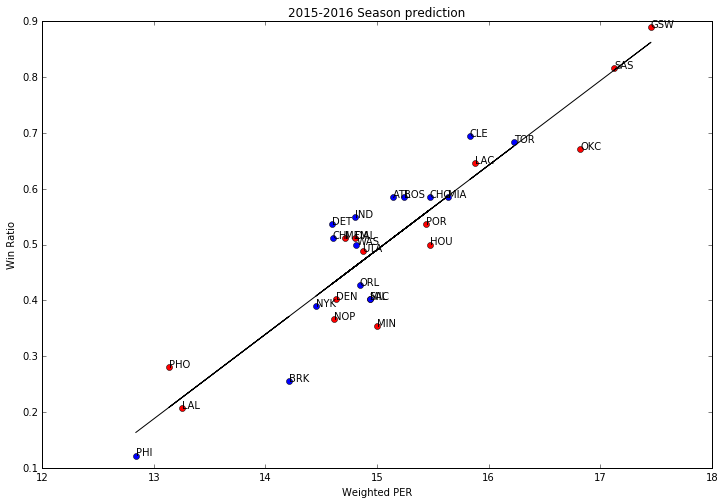

In [5]:
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Teams = ['SAS','GSW','OKC','CLE','TOR','LAC','ATL','BOS','CHO','UTA','IND','MIA','POR','DET','HOU','DAL','WAS','CHI','ORL','MEM','SAC','DEN','NYK','NOP','MIN','MIL','PHO','BRK','LAL','PHI']
Wins_train = []
Conf_train = []
TeamFull = []
with open('./sample_datafiles/16team.csv', 'rb') as csvfile:
     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
     for row in spamreader:
         if row[1]!='Team':
             Wins_train.append(float(row[6]))
             Conf_train.append(int(row[2] == 'W'))
             TeamFull.append(row[1])
PERAvg_train = np.zeros(30)
GP_train = np.zeros(30)
Min_train = np.zeros(30)
with open('./sample_datafiles/2015-2016.csv', 'rb') as csvfile:
     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
     
     for row in spamreader:
        if row[0]!='"Rk' and row[4]!='TOT':
            team = row[4]
            mins = row[6]
            gp = row[5]
            index = Teams.index(team)
            if float(mins)/float(gp) > 8.0:
                GP_train[index] += int(gp)
                Min_train[index] += int(mins)
                PERAvg_train[index] += float(row[7]) * int(mins)
PERAvg_train /= Min_train
PERAvg_train = np.array(PERAvg_train).reshape((30,1))
Wins_train = np.array(Wins_train).reshape((30,1))
Conf = np.array(Conf_train).reshape((30,1))
X = np.zeros((30,2))

from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(PERAvg_train, Wins_train)
print regr.score(PERAvg_train, Wins_train)
print regr.coef_
print regr.intercept_
fitted = regr.predict(PERAvg_train)
colors = ['b','r']
plt.figure(figsize=(12,8))

for i in range(30):
    plt.plot(PERAvg_train[i], Wins_train[i],str(colors[int(Conf[i])])+'o')
    plt.annotate(Teams[i], xy=(PERAvg_train[i],Wins_train[i]), xytext=(PERAvg_train[i], Wins_train[i]))
plt.plot(PERAvg_train, fitted, 'k')
plt.ylabel("Win Ratio")
plt.xlabel("Weighted PER")
plt.title("2015-2016 Season prediction")
plt.show()
##############################################

#### Data Scraping and API Building 

As for building this project in the sense of an API I wrap the above models into an applicaiton that allows for user inputs as the queries to be made, and
the model outputs results based on the kind of queries made. This would require instant access to the database. For this purpose I used the BeautifulSoup
package and, for example using the code below for seasonal advanced stats, scrapes that specific page of data from basketball-reference.com website tables into string lists as the database, which can be done once given the
year of the season to be analyzed. The code is sensitive to the specifics of the kind of data to be acquired. Once the advanced stats are scraped into 
lists of strings, you can then run the program from above with minor changes.

In [6]:
#regular season data scraping
advanced_17 = 'http://www.basketball-reference.com/leagues/NBA_2017_advanced.html'

req = requests.get(advanced_17) 

text = BeautifulSoup(req.text, 'html.parser')
stats = text.find('div',{'id': 'all_advanced_stats'}) 

# find the schema 


In [7]:
cols = [i.get_text() for i in stats.thead.find_all('th')] 

# convert from unicode to string 
cols = [x.encode('UTF8') for x in cols] 

# get rows 
rows=[]
for i in stats.tbody.find_all('tr'):
    cols = [j.get_text() for j in i.find_all('td')] 
    
    row_i = [x.encode('UTF8') for x in cols]
    
    rows.append(row_i)

#print rows[0]

In [8]:
team_17 = 'http://www.basketball-reference.com/leagues/NBA_2017_ratings.html'
req = requests.get(team_17) 

text = BeautifulSoup(req.text, 'html.parser')
stats = text.find('div',{'id': 'all_ratings'}) 

In [9]:
cols = [i.get_text() for i in stats.thead.find_all('th')] 

# convert from unicode to string 
cols = [x.encode('UTF8') for x in cols] 
#print cols
# get rows 
teams=[]
for i in stats.tbody.find_all('tr'):
    cols = [j.get_text() for j in i.find_all('td')] 
    
    row_i = [x.encode('UTF8') for x in cols]
    
    teams.append(row_i)



From the generated rows ndarray we can easily modify the indices and reframe the data to fit the method used above.

0.643471230556


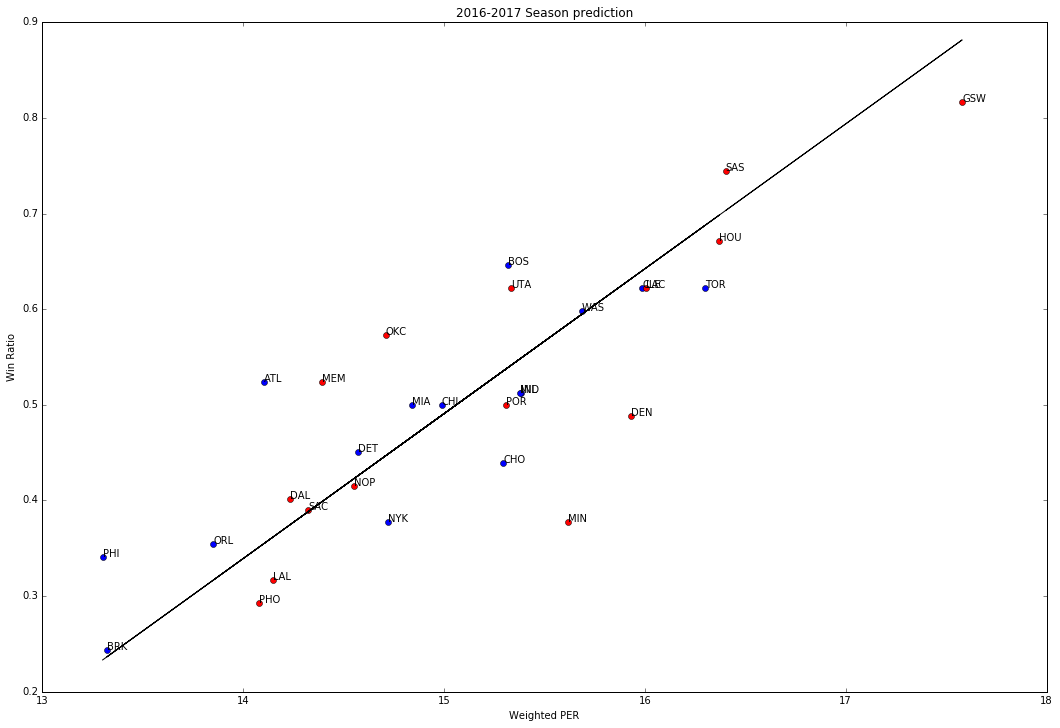

In [10]:
Wins = np.zeros(30)

for team in teams:
    
    index = TeamFull.index(team[0])
    Wins[index] = float(team[5])
            
PERAvg = np.zeros(30)
GP = np.zeros(30)
Min = np.zeros(30)

for row in rows:
    if len(row)==0:
        continue
    if row[3]!='TOT':
        team = row[3]
        mins = row[5]
        gp = row[4]
        index = Teams.index(team)
        if float(mins)/float(gp) > 8.0:
            GP[index] += int(gp)
            Min[index] += int(mins)
            PERAvg[index] += float(row[6]) * int(mins)
PERAvg /= Min
PERAvg = np.array(PERAvg).reshape((30,1))
Wins = np.array(Wins).reshape((30,1))


####
predicted = regr.predict(PERAvg)


####
print regr.score(PERAvg, Wins)
colors = ['b','r']
plt.figure(figsize=(18,12))

for i in range(30):
    plt.plot(PERAvg[i], Wins[i],str(colors[int(Conf[i])])+'o')
    plt.annotate(Teams[i], xy=(PERAvg[i],Wins[i]), xytext=(PERAvg[i], Wins[i]))
plt.plot(PERAvg, predicted, 'k')
plt.ylabel("Win Ratio")
plt.xlabel("Weighted PER")
plt.title("2016-2017 Season prediction")
plt.show()

The above test result gives us confidence in the regression model. More past seasons' data can be added to the training data to make it larger and 
more comprehensive. 

### Game Prediction 

The game margin prediction and game winner prediction can be very useful for betting line decision and other practical uses. This is also a main concern
for the basketball fans. 
In the NBA Predictor module, game winner prediction is done by a logistic regression using the home team's weighted PER and the guest team's weighted PER.
The binary indicator for home court advantage is integrated into the home team coefficient representing an interaction effect. The model gives a probability
of winning for the home team as the result and the logistic regression accuracy is around 0.65. The data scraping procedures are like the seasonal prediction part but we are
now scraping the data for the per game results instead of a seasonal winning ratio.
Game margin prediction is a linear regression witht the same features as the logistic regression but with the score differences as the y-variables.The result is about 0.2 $R^2$, which is reasonable due to the high variance of game score results.

### Momentum Quantification in per game results prediction 

An extension of what was done above is to add in a new fact: the momentum of the team in concern. For example, a team that comes in this game
following a winning streak of ten is clearly highly motivated and may perform above their expected level and vice versa. Therefore by discounting the effect
of previous winning and losing streaks and adding a regressor for momentum in the regression models above we can get a more realistic prediction model.
We can think of a previous period of k games that have residual effect on the team's current momentum. Count the number of streaks in the k games and 
denote them by $s_1,s_2,s_3....s_n$ while $s_1$ is the most recent streak. 
For a winning streak $s_i$ its length $a_i = |s_i|$ is added to the total momentum as $a_i d^i$, while for a losing streak the negative value is added.
Clearly this way we assign heavier weight to more recent streaks and longer streaks get awarded more.
Then we will have a total momentum M for this team and we can calculate the opposing team's momentum likewise.
Notice that in this calculation k and d are hyperparameters that we can decide. I plan to work on some experiments and assign appropriate values to k and d.



Preliminary test results for implementing the momentum factor from winning or losing streaks into the team's current game prediction models are shown below. 
As a starter, I tested how to calculate and choose hyperparameters that represent the momentum factor in a real life sense. 
The test code incorporates function to calculate momentum in a previous period from the current game date. 
Boston Celtics was chosen as a test case team and the momentum time series for its 2016-2017 season results was plotted using different parameters. 
In particular, rolling winsow sizes k=10 and k=5 are tested and discount factors d=0.9 and d=0.5 are used and the result for d=0.9 is shown.
I integrated the team's momentum as another feature in the previous game prediction models, using k=10 and d=0.9.
The application will record all game results in the current season and store them in a timely series for each team so that when asked for a specific team's momentum, the calculation will be easier.
The result shows an increase of game winner prediction accuracy to 0.7 and the $R^2$ for game margin prediction increased to about 0.3.In the web application, the results will also show the two team's current season momentum flow chart like the one demonstrated below.

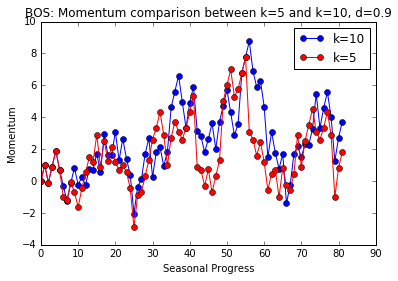

In [4]:
from bs4 import BeautifulSoup
import requests

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def calc_momentum(k_period,d):
        n = len(k_period)
        if n==0:
            return 0
        init = k_period[0]
        flag = int(init[0])
        streak = int(init[1])
        momentum = 0
        for i in range(1,n):
            cur = k_period[i]
            flag_cur = int(cur[0])
            streak_cur = int(cur[1])
            if flag_cur==0 and flag==1:
                momentum*=d
                momentum+=streak*d
                flag = flag_cur
                streak = streak_cur
            elif flag_cur==1 and flag==0:
                momentum*=d
                momentum+= -streak*d
                flag = flag_cur
                streak = streak_cur
            else:
                flag = flag_cur
                streak = streak_cur
        if flag==1:
            momentum+=streak
        else:
            momentum-=streak
        return momentum
#example input
season = 2017
team = 'BOS'
#find team schedule and results
team_schedule = 'https://www.basketball-reference.com/teams/'+team+'/'+str(season)+'_games.html'
req = requests.get(team_schedule) 
text = BeautifulSoup(req.text, 'html.parser')
stats = text.find('div',{'id': 'all_games'}) 
cols = [i.get_text() for i in stats.thead.find_all('th')] 

    # convert from unicode to string 
cols = [x.encode('UTF8') for x in cols] 
#print cols
records = []
for i in stats.tbody.find_all('tr'):
        cols = [j.get_text() for j in i.find_all('td')] 
        row_i = [x.encode('UTF8') for x in cols]
        #store results in the records matrix
        if len(row_i)==14:
            date = row_i[0].split(',')[1][1:]
            home = len(row_i[4])
            opponent = row_i[5]
            #this records current game winning of losing
            result = int(row_i[12][0]=='W')
            #this records the current streak
            streak = int(row_i[12][2])
            records.append([date,home,opponent,result,streak])
records = np.array(records)
dates = list(records[:,0])
games_count = len(dates)
#example test momentum calculation for the 16-17 season in a moving 10 window
m_list_5 = [] 
m_list_10 = []
#hyperparameters k and d
k = 10
d = 0.9
for curgame_date in dates:
    #find its position in the team scheduls
    where = dates.index(curgame_date)
    #find previous k game  period, if current season has played less than k games, then return all that have been played   
    if where>=k:
        pre_period = records[where-k:where,3:5]
    else: 
        pre_period = records[0:where,3:5]
   
    moment = calc_momentum(pre_period,d)
    m_list_10.append(moment)
m_list_10 = np.array(m_list_10)
plt.plot(range(games_count),m_list_10,'bo-',label='k=10')
k = 5
for curgame_date in dates:
    #find its position in the team scheduls
    where = dates.index(curgame_date)
    #find previous k game  period, if current season has played less than k games, then return all that have been played 
    if where>=k:
        pre_period = records[where-k:where,3:5]
    else: 
        pre_period = records[0:where,3:5]  
    moment = calc_momentum(pre_period,d)
    m_list_5.append(moment)
m_list_5 = np.array(m_list_5)
plt.plot(range(games_count),m_list_5,'ro-',label='k=5')
plt.xlabel('Seasonal Progress')
plt.ylabel('Momentum')
plt.title(team+': Momentum comparison between k=5 and k=10, d='+str(d))
plt.legend(loc='upper right')

## Player Contract Prediction

I plan to develop the NBA predictor module prototype into a more team operations focused data science project.
In particular the module targets at addressing questions such as the following in a quantitative way:
    
1. How important is an individual player to the team's success?
2. How to define similarity between two players?
3. How to decide what kind of contract extension for a player is suitable from the team's perspective?
4. How to judge if a player presents intangible assets on team's performance or success?
5. How to evaluate a trade?

The first model that I implemented is a player contract prediction model. It uses a nonlinear regression with features such as PER,Win Share,player position,minutes per game, etc.Salary is a relevant variable here in terms of the current season's cap salary for a team. So my y-variable is the percentage of cap salary filled by an individual player's salary.
 To get the real salary value we can just multiply the prediction with current season's cap value. This adjusts for past seasons salaries so that I can extend the database.
From observation on the dataset I assumed quadratic effect of PER on the salaries. I also included an interaction term of PER*Minutes Per Game.
Rookies are excluded from the prediction because their salaries are fixed.
 To enhance robustness against significant outliers, which tend to occur in player contract signing,I used Huber regressor with epsilon=1 instead of the usual linear regression. The regression $R^2$ is generally 0.6 for both training and testing.
The features also included five indicators for different positions, which is intuitively influencial in contract values.


## Similar Player Recommendation System

From the player contract prediction model, I went one step further and gave a recommendation of similar players based on the input player name.
To define similarity, I thinked of it not only as how the two players contribute to the team, but also as how their playing style tends to be.
In particular I looked at many advanced and basic statistics and weighted them in terms of their significance in determinig player similarity.
Some of the most important features are: points per 36 minutes, true shooting percentage, 3 pointer attempt ratio, field goals attempted per 36 minutes, turnover ratio, assit ratio...
After constructing a characteristics vector for each player, I centralize it to be a z-score from the average of the player's position.
Similarity is caluclated using an average of the cosine similarity between two vectors and an absolute difference between two vectors, both weighted with a previously defined weighting vector.
Then from the user defined player base, five top similarity rated player will be chosen to be displayed on the web application for the user's reference.This idea of item similarity filtering can be applied with more features for consideration.

## Perspectives  (may not all be completed)

Proposed for future development:
    
- Quantification of intangible assets presented by a player that contributes to team success.

## References:

Basketball Analytics, Stephen M.Shea and Christopher E.Baker, Advanced Metrics LLC, 2013.

www.basketball-reference.com
